In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Bragg Grating/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Bragg Grating/SimulationFiles/'))
spec_win.loader.exec_module(lumapi)

In [9]:
bragg = lumapi.MODE(filename='BRAGGProject.lms',hide=False) 

## Functions

In [10]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })

## Assembly parameters

In [11]:
SilH = 450e-9 # Silicon height
SilW = 220e-9 # Silicon width

GlassH = 1e-6 # SiO2 height

## Index variation calculation

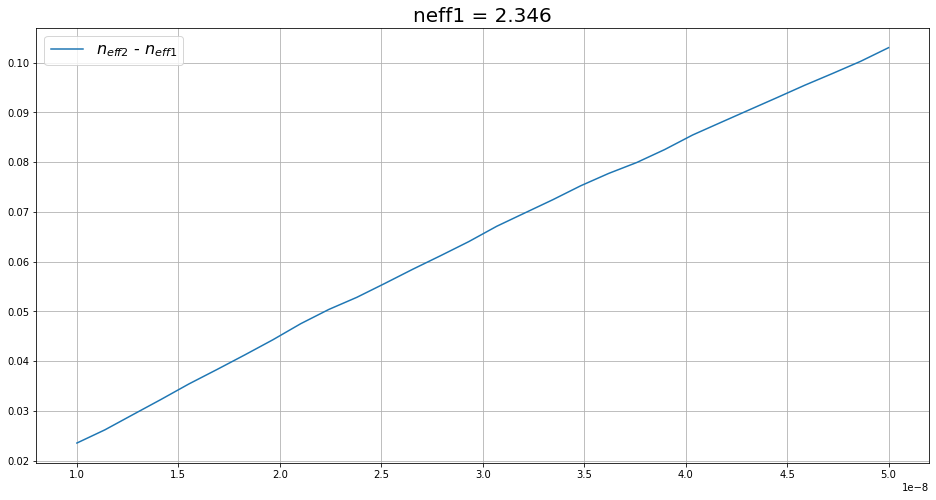

In [47]:
points = 30                               # Number of points
deltaW = np.linspace(10e-9,50e-9,points)  # Teeth heigth matrix

bragg.switchtolayout()
bragg.deleteall()

# Substract insert
RectInsert(0, 5e-6, 0, GlassH*2, -(SilW+GlassH)/2, GlassH, "SiO2 (Glass) - Palik", bragg)
bragg.set("name", "Substract")

bragg.addfde()
bragg.setanalysis("wavelength", 1500e-9)
bragg.setanalysis("number of trial modes",2)
bragg.set("solver type", "2D X normal")
bragg.set({"x":0, "y":0, "z":0, "y span":1e-6, "z span":1e-6,
           "mesh cells y":200, "mesh cells z":200,
           "y min bc":"PML", "y max bc":"PML", "z min bc":"PML", "z max bc":"PML"})

RectInsert(0, 5e-6, 0, SilH, 0, SilW, "Si (Silicon) - Palik", bragg)
bragg.set("name", "Waveguide")
bragg.findmodes()
neff1 = np.real(bragg.getdata("FDE::data::mode1","neff"))

neff2 = np.zeros(points)

for i in range(points):
    bragg.switchtolayout()
    bragg.select("Waveguide")
    bragg.set({"x":0, "x span":5e-6, "y":0, "y span":SilH+deltaW[i], "z":0, "z span":SilW,
               "material":"Si (Silicon) - Palik"})
    bragg.findmodes()
    neff2[i] = np.real(bragg.getdata("FDE::data::mode1","neff"))

plt.figure(figsize=(16, 8))
plt.title("neff1 = {:.3f}".format(neff1[0][0]), fontsize=20)
plt.plot(deltaW,neff2 - neff1[0][0],label=r"$n_{eff2}$ - $n_{eff1}$")
plt.xlabel(r'$\Delta W$', fontsize=16)
plt.ylabel(r'$\Delta n$', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

